In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# from sklearn.cross_validation import train_test_split
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split

import numpy as np
import cv2
from skimage.feature import hog

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, block_norm='L1',
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec, block_norm=block_norm)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec, block_norm=block_norm)
        return features
    
def extract_features(imgs, spatial_size=(32, 32), hist_bins=32, 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL',block_norm='L1',
                     comb_list=['color_hist', 'spatial', 'hog']):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one, scale to 1
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image)
        
        spatial_features = []
        hist_features = []
        hog_features = []
        
        if 'spatial' in comb_list:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        if 'color_hist' in comb_list:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
        
        if 'hog' in comb_list:
            if hog_channel == 'ALL':
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, block_norm,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, pix_per_cell, cell_per_block, block_norm, 
                                                vis=False, feature_vec=True)
                    
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [3]:
def single_img_features(image, spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL',block_norm='L1',
                        comb_list=['color_hist', 'spatial', 'hog']):    
    features = []
        
    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image)
        
    spatial_features = []
    hist_features = []
    hog_features = []
        
    feature_image = feature_image / 255.
        
    if 'color_hist' in comb_list:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
    
    if 'spatial' in comb_list:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
    if 'hog' in comb_list:
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):                
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, block_norm,
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, block_norm,
                                        vis=False, feature_vec=True)
                    
    return np.concatenate((spatial_features, hist_features, hog_features))

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, 
                   svc, X_scaler, spatial_size, hist_bins,
                   orient, pix_per_cell,cell_per_block,block_norm, hog_channel):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
    
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,block_norm=block_norm,
                                       hog_channel=hog_channel)
        
        #5) Scale extracted features to be fed to classifier
        X = np.asarray(features.reshape(1, -1)).astype(np.float64)
        X = scaler.transform(X)
        
        #6) Predict using your classifier
        y = clf.predict(X)
            
        #7) If positive (prediction == 1) then save the window
        if y == 1:
            on_windows.append(window)
    
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

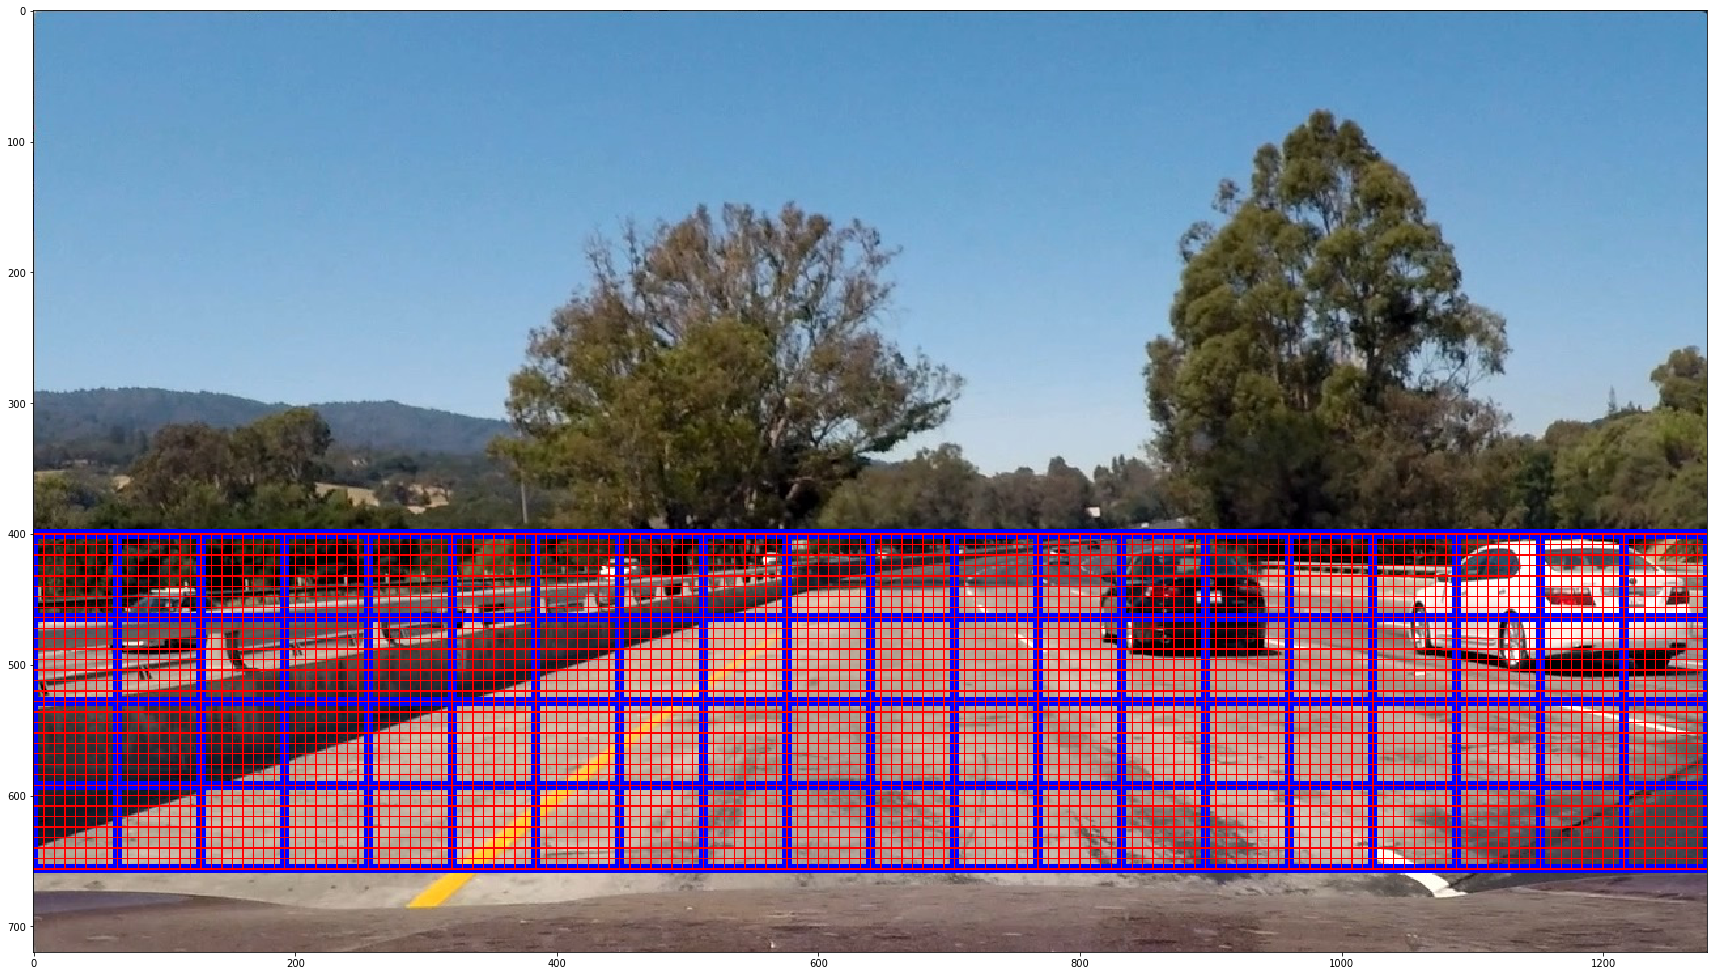

In [4]:
image = mpimg.imread('test_images/test1.jpg')
small_windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(400, 656), 
                      xy_window=(8, 8), xy_overlap=(0, 0))

large_windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(400, 656), 
                      xy_window=(64, 64), xy_overlap=(0, 0))

window_img = draw_boxes(image, large_windows, color=(0, 0, 255), thick=6)
window_img = draw_boxes(window_img, small_windows, color=(255, 0, 0), thick=1)

plt.figure(figsize=(30,30))
plt.imshow(window_img)

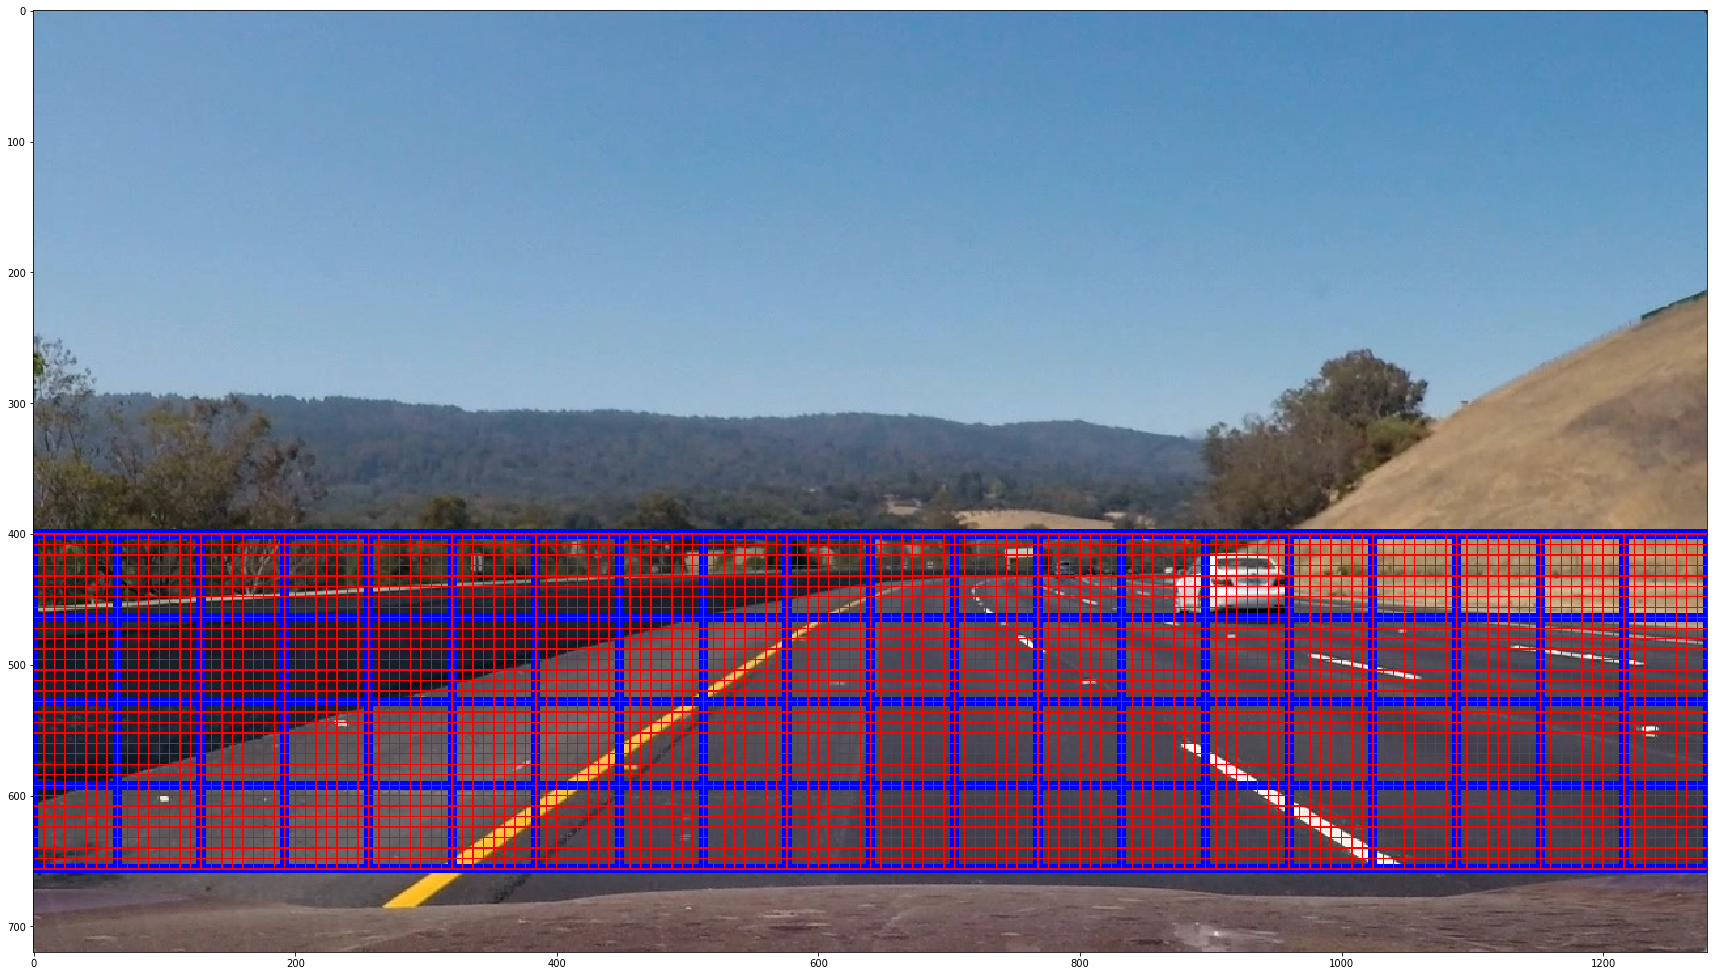

In [5]:
image = mpimg.imread('test_images/test3.jpg')
small_windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(400, 656), 
                      xy_window=(8, 8), xy_overlap=(0, 0))

large_windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(400, 656), 
                      xy_window=(64, 64), xy_overlap=(0, 0))

window_img = draw_boxes(image, large_windows, color=(0, 0, 255), thick=6)
window_img = draw_boxes(window_img, small_windows, color=(255, 0, 0), thick=1)

plt.figure(figsize=(30,30))
plt.imshow(window_img)

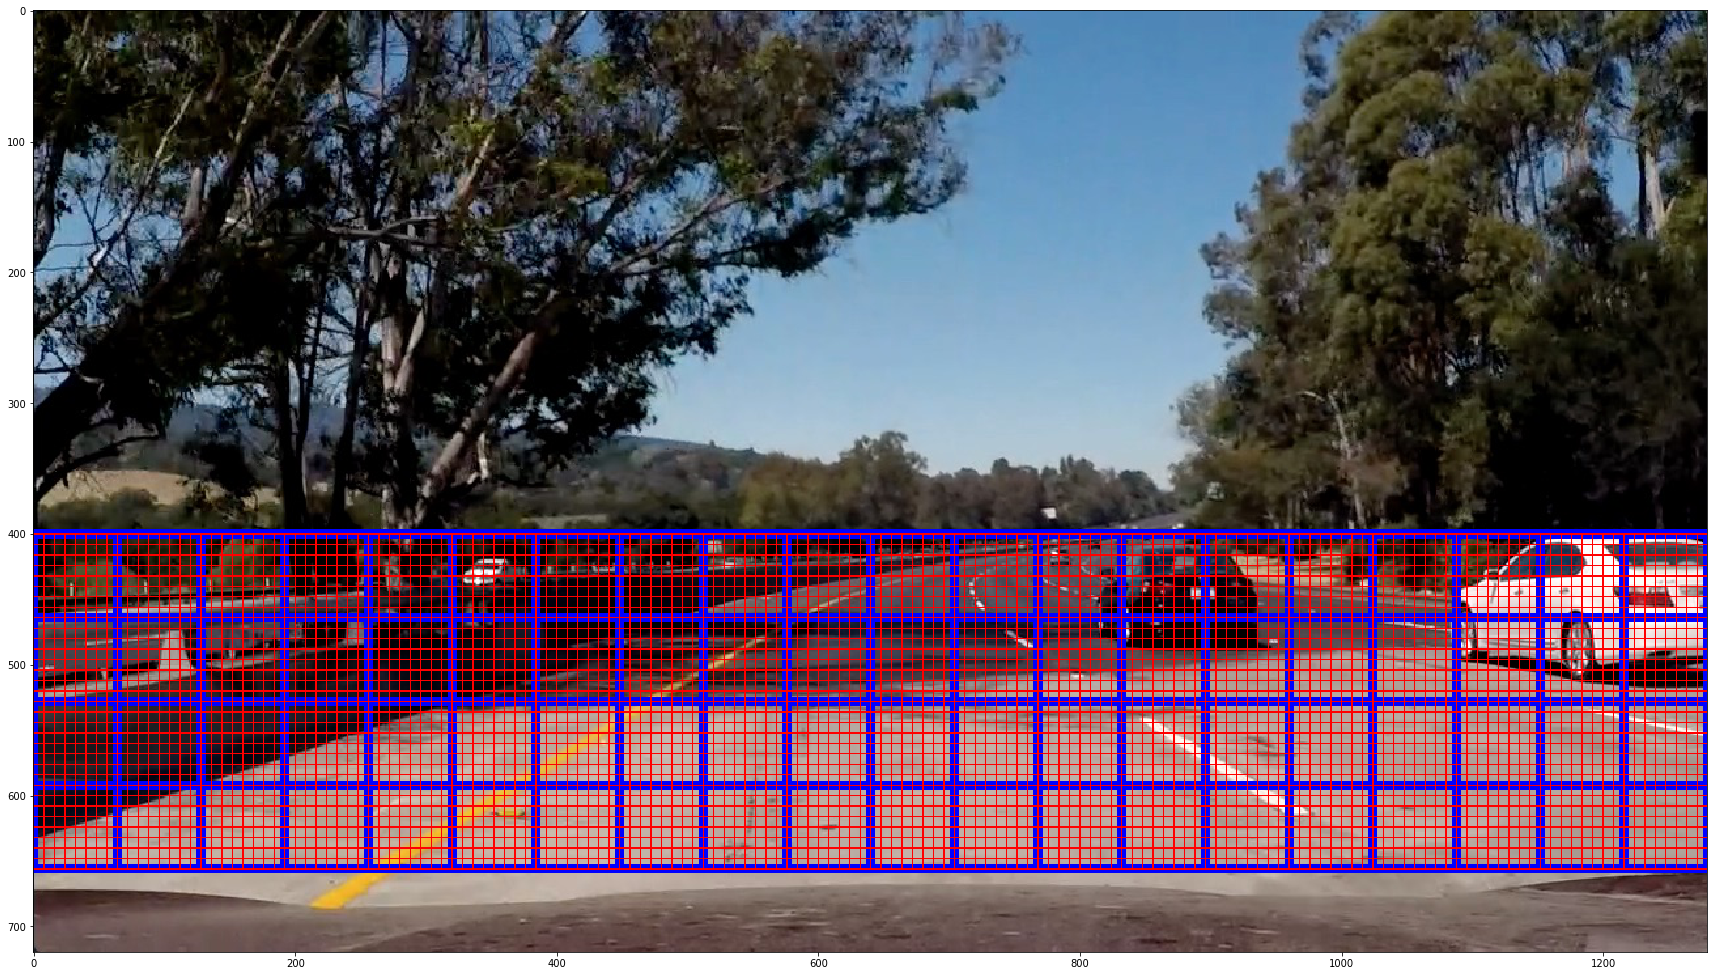

In [6]:
image = mpimg.imread('test_images/test5.jpg')
small_windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(400, 656), 
                      xy_window=(8, 8), xy_overlap=(0, 0))

large_windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(400, 656), 
                      xy_window=(64, 64), xy_overlap=(0, 0))

window_img = draw_boxes(image, large_windows, color=(0, 0, 255), thick=6)
window_img = draw_boxes(window_img, small_windows, color=(255, 0, 0), thick=1)

plt.figure(figsize=(30,30))
plt.imshow(window_img)

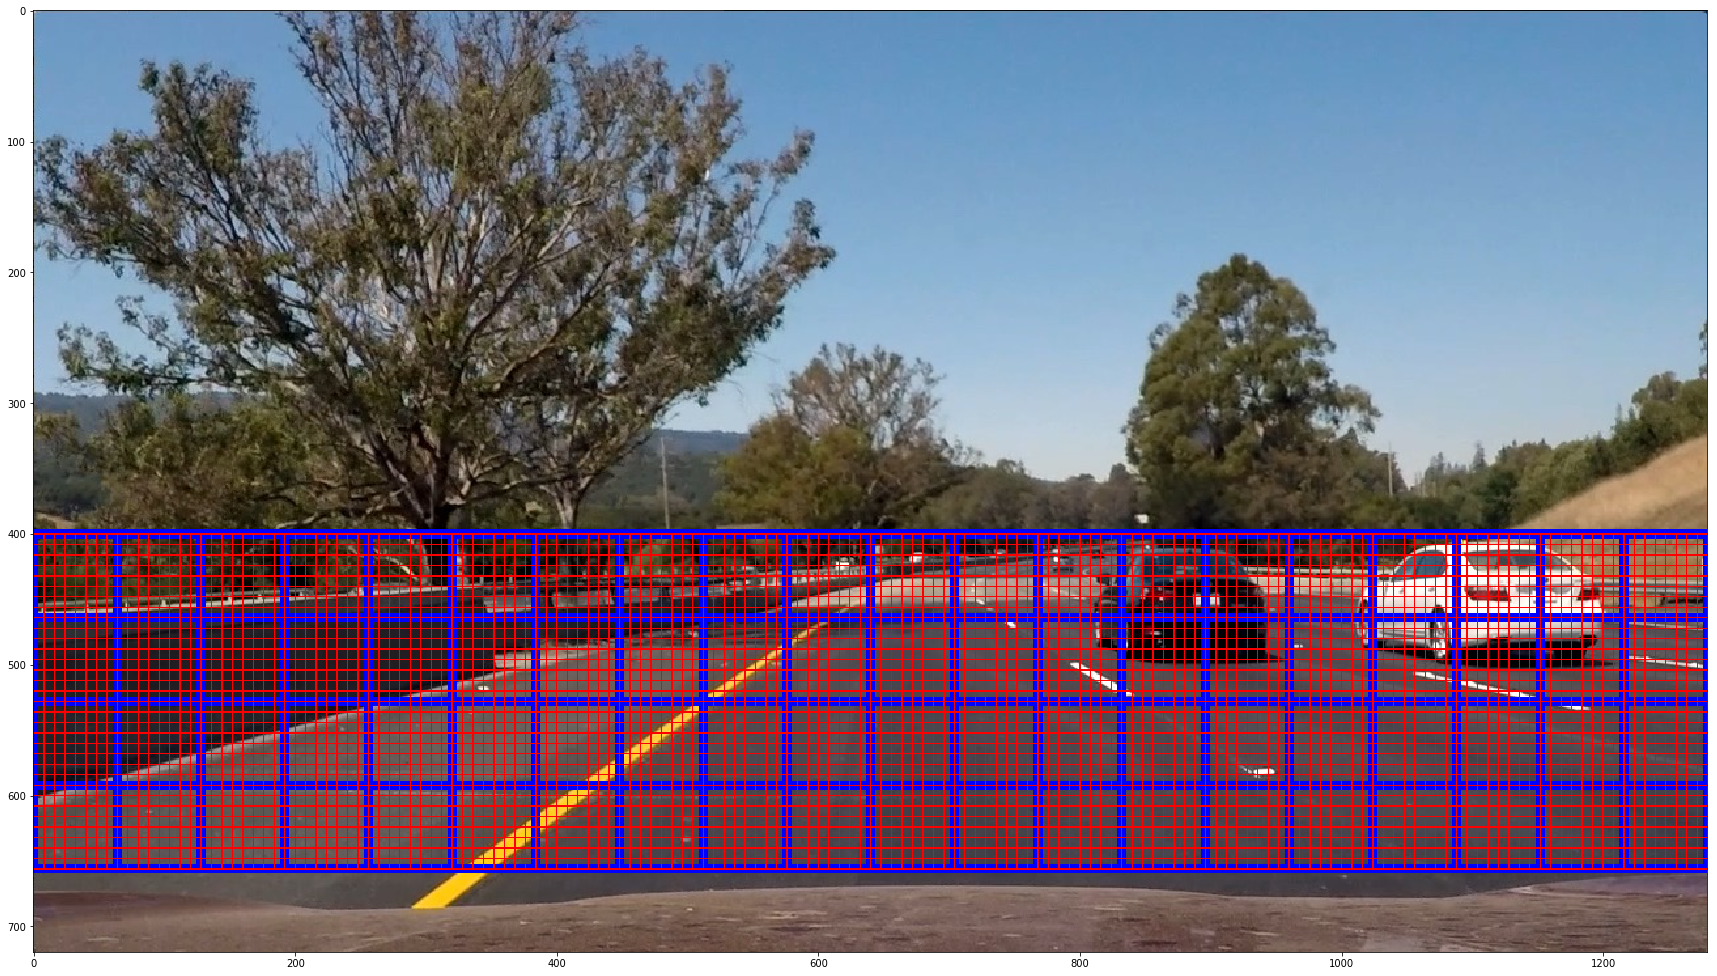

In [7]:
image = mpimg.imread('test_images/test6.jpg')
small_windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(400, 656), 
                      xy_window=(8, 8), xy_overlap=(0, 0))

large_windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(400, 656), 
                      xy_window=(64, 64), xy_overlap=(0, 0))

window_img = draw_boxes(image, large_windows, color=(0, 0, 255), thick=6)
window_img = draw_boxes(window_img, small_windows, color=(255, 0, 0), thick=1)

plt.figure(figsize=(30,30))
plt.imshow(window_img)

spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=ALL,comb_list=['color_hist', 'spatial', 'hog'],block_norm=L1


/home/sunkai/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


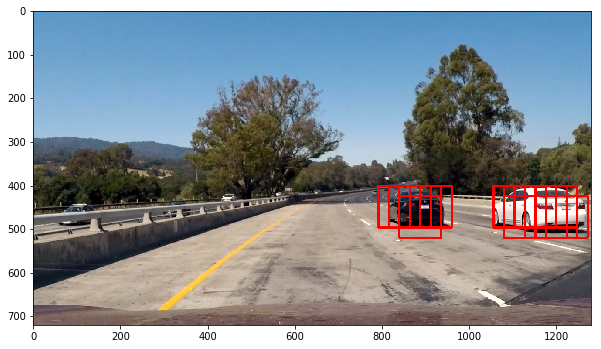

In [8]:
%matplotlib inline  

import pickle
dist_pickle = pickle.load(open("./models/svc_model.p", "rb" ))

svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle['hog_channel']
comb_list = dist_pickle['comb_list']
block_norm = dist_pickle['block_norm']


print("spatial_size=%s, hist_bins=%s, orient=%s, pix_per_cell=%s, cell_per_block=%s, hog_channel=%s,\
comb_list=%s,block_norm=%s" %(spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
comb_list, block_norm))


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, spatial_size, hist_bins,
              orient, pix_per_cell, cell_per_block, hog_channel, comb_list, block_norm):
    box_list = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, block_norm=block_norm, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, block_norm=block_norm, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, block_norm=block_norm, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)                
                box_list.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                
    return box_list
    
ystart = 400
ystop = 656
scale = 1.5

image = mpimg.imread('test_images/test1.jpg')
box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, spatial_size, hist_bins,
                     orient, pix_per_cell, cell_per_block, hog_channel, comb_list, block_norm)
out_img = draw_boxes(image, box_list, color=(255, 0, 0), thick=3)                    

plt.figure(figsize=(10,10))
plt.imshow(out_img)

/home/sunkai/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


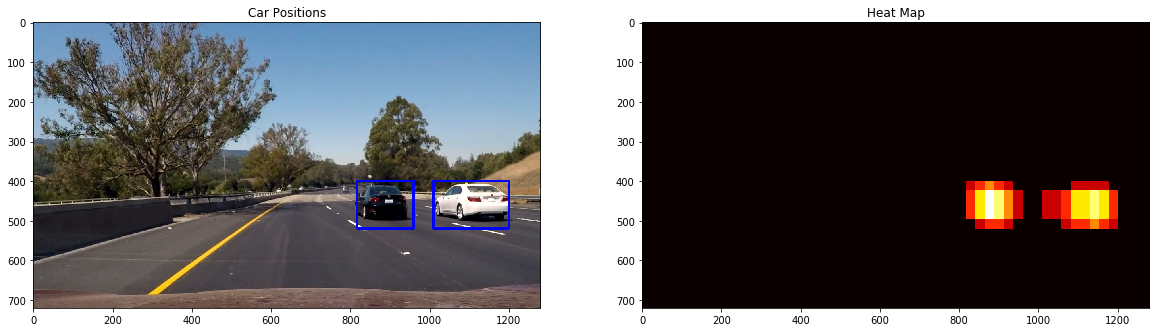

In [9]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Search block list
ystart = 400
ystop = 656
scale = 1.5
image = mpimg.imread('test_images/test6.jpg')
box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, spatial_size, hist_bins,
                     orient, pix_per_cell, cell_per_block, hog_channel, comb_list, block_norm)

# Add heat to each box in box list
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
# fig.tight_layout()

In [10]:
import pickle
from collections import deque

max_queue_len = 5
img_width = 1280
img_height = 720

class SVCVehicleTracker:
    
    def __init__(self):
        
        # Load svc model parameters
        dist_pickle = pickle.load(open("./models/svc_model.p", "rb" ))
        self.svc = dist_pickle["svc"]
        self.X_scaler = dist_pickle["scaler"]
        self.spatial_size = dist_pickle["spatial_size"]
        self.hist_bins = dist_pickle["hist_bins"]
        self.orient = dist_pickle["orient"]
        self.pix_per_cell = dist_pickle["pix_per_cell"]
        self.cell_per_block = dist_pickle["cell_per_block"]
        self.hog_channel = dist_pickle['hog_channel']
        self.comb_list = dist_pickle['comb_list']
        self.block_norm = dist_pickle['block_norm']
        
        print("Loading model paramters:\nspatial_size=%s, hist_bins=%s, orient=%s, pix_per_cell=%s, cell_per_block=%s, hog_channel=%s,\
               comb_list=%s,block_norm=%s" %(self.spatial_size, self.hist_bins, self.orient, self.pix_per_cell, self.cell_per_block, self.hog_channel,
               self.comb_list, self.block_norm))
        
        # Sliding window search configurations
        self.threshold = 1.5
        
        self.frame_no = 0
        self.current_heat = None
        self.max_queue_len = max_queue_len
        self.heat_queue = np.zeros((max_queue_len, img_height, img_width))
        self.heat_queue_ind = 0
        
        self.ystart_ystop_scale_cfgs = [(400, 464, 384, 640, 1), (400, 592, 0, 1280, 1.5)]
        
        print("Loading sliding window configurations:\nthreshold=%s,max_queue_len=%s,ystart_ystop_scale_cfgs=%s" 
              % (self.threshold, self.max_queue_len, self.ystart_ystop_scale_cfgs))
        
    @staticmethod
    def find_bbox_list(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, spatial_size, hist_bins,
                       orient, pix_per_cell, cell_per_block, hog_channel, comb_list, block_norm):
        bbox_list = []
    
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255
        img_tosearch = img[ystart:ystop,xstart:xstop,:]

        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, block_norm=block_norm, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, block_norm=block_norm, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, block_norm=block_norm, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)                
                    bbox_list.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

        return bbox_list
    
    @staticmethod
    def add_heat(heatmap, bbox_list, weight = 1):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1 * weight

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes
    
    @staticmethod
    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    @staticmethod
    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    @staticmethod
    def draw_boxes(img, bboxes, color=(255, 0, 0), thick=3):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy
    
    def apply(self, img, debug=True):
        self.frame_no = self.frame_no + 1
        draw_img = np.copy(img)
        
        # Processing current frame
        bbox_list = []
        for cfg in self.ystart_ystop_scale_cfgs:
            ystart = cfg[0]
            ystop = cfg[1]
            xstart = cfg[2]
            xstop = cfg[3]
            scale = cfg[4]
            
            bboxes = self.find_bbox_list(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, spatial_size, hist_bins,
                         orient, pix_per_cell, cell_per_block, hog_channel, comb_list, block_norm)
            bbox_list.extend(bboxes)
        
        # Processing heat of current frame
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = self.add_heat(heat, bbox_list, 1)
        self.current_heat = np.copy(heat)
        
        # Enqueue the heat of current frame
        self.heat_queue = self.heat_queue * 0.6
        self.heat_queue_ind = (self.heat_queue_ind + 1) % self.max_queue_len 
        self.heat_queue[self.heat_queue_ind] = self.current_heat
        
        # Sum over all the frames in the queue
        heat = np.sum(self.heat_queue, axis=0)
        
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, self.threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(draw_img, labels)

        if debug:
            debug_img = self.draw_boxes(img, bbox_list)
            text = "Frame No.: " + str(self.frame_no)
            cv2.putText(debug_img, text, (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            
            return np.concatenate((draw_img, debug_img), axis=1)
        else:
            return draw_img

Loading model paramters:
spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=ALL,               comb_list=['color_hist', 'spatial', 'hog'],block_norm=L1
Loading sliding window configurations:
threshold=1.5,max_queue_len=5,ystart_ystop_scale_cfgs=[(400, 464, 384, 640, 1), (400, 592, 0, 1280, 1.5)]


/home/sunkai/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


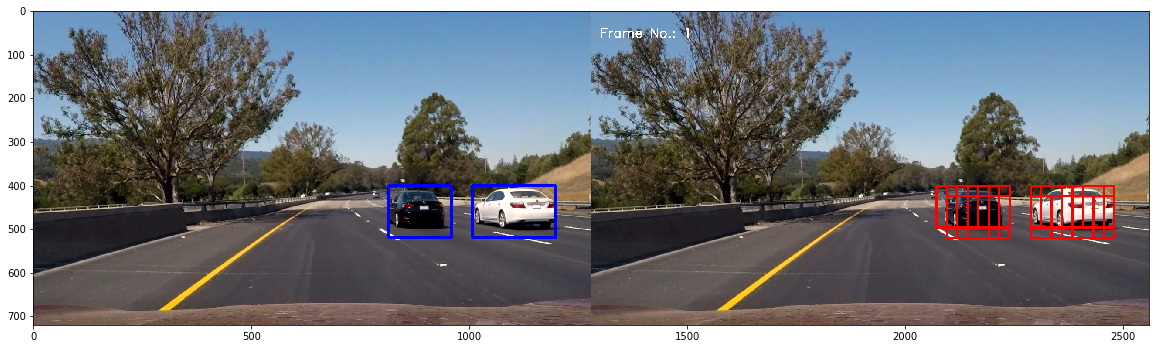

In [11]:
image = mpimg.imread('test_images/test6.jpg')
tracker = SVCVehicleTracker()
result_image = tracker.apply(image, debug=True)
plt.figure(figsize=(20, 10))
plt.imshow(result_image)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_pipeline(image):
    return tracker.apply(image, process_pipeline.debug)

tracker = SVCVehicleTracker()
process_pipeline.debug=True

output = './output_videos/test_video_output.mp4'
clip = VideoFileClip("./test_video.mp4")
clip_1 = clip.fl_image(process_pipeline)
%time clip_1.write_videofile(output, audio=False)

Loading model paramters:
spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=ALL,               comb_list=['color_hist', 'spatial', 'hog'],block_norm=L1
Loading sliding window configurations:
threshold=1.5,max_queue_len=5,ystart_ystop_scale_cfgs=[(400, 464, 384, 640, 1), (400, 592, 0, 1280, 1.5)]
[MoviePy] >>>> Building video ./output_videos/test_video_output.mp4
[MoviePy] Writing video ./output_videos/test_video_output.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  3.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_output.mp4 

CPU times: user 15.2 s, sys: 410 ms, total: 15.6 s
Wall time: 14.1 s


In [ ]:
tracker = SVCVehicleTracker()
process_pipeline.debug=False

output = './output_videos/project_video_output.mp4'
clip = VideoFileClip("./project_video.mp4")
clip_1 = clip.fl_image(process_pipeline)
%time clip_1.write_videofile(output, audio=False)

Loading model paramters:
spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=ALL,               comb_list=['color_hist', 'spatial', 'hog'],block_norm=L1
Loading sliding window configurations:
threshold=1.5,max_queue_len=5,ystart_ystop_scale_cfgs=[(400, 464, 384, 640, 1), (400, 592, 0, 1280, 1.5)]
[MoviePy] >>>> Building video ./output_videos/project_video_output.mp4
[MoviePy] Writing video ./output_videos/project_video_output.mp4


 18%|█▊        | 221/1261 [01:12<05:44,  3.01it/s]